In [49]:
import scipy, math, eli5
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from scipy.cluster import hierarchy as hc
from pdpbox import pdp
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('BlackFriday.csv')
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


In [4]:
df.shape[0]

537577

In [33]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.375770e+05,537577.00000,537577.000000,537577.000000,370591.000000,164278.000000,537577.000000
mean,1.002992e+06,8.08271,0.408797,5.295546,9.842144,12.669840,9333.859853
std,1.714393e+03,6.52412,0.491612,3.750701,5.087259,4.124341,4981.022133
min,1.000001e+06,0.00000,0.000000,1.000000,2.000000,3.000000,185.000000
25%,1.001495e+06,2.00000,0.000000,1.000000,5.000000,9.000000,5866.000000
50%,1.003031e+06,7.00000,0.000000,5.000000,9.000000,14.000000,8062.000000
75%,1.004417e+06,14.00000,1.000000,8.000000,15.000000,16.000000,12073.000000
max,1.006040e+06,20.00000,1.000000,18.000000,18.000000,18.000000,23961.000000


In [5]:
df.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

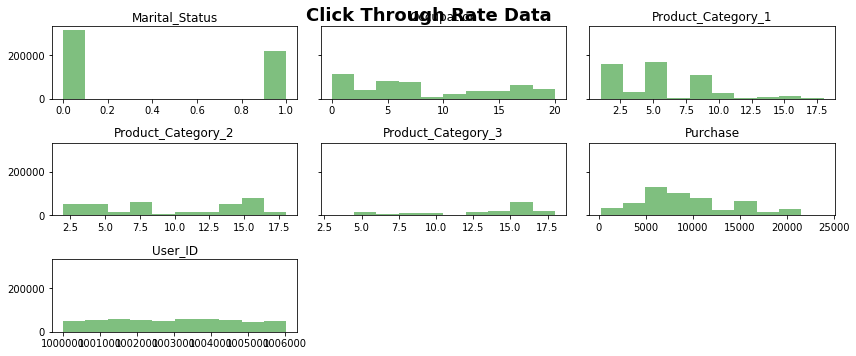

In [30]:
def plot_hist(df, title, color):
    df.hist(figsize=(12, 5), sharey=True, grid=False, color=color, alpha=0.5)
    plt.suptitle(title, size=18, weight='bold')
    plt.tight_layout()
    plt.show()

plot_hist(df, 'Click Through Rate Data', 'g')

In [6]:
filled_df = df.fillna(-1).copy()

In [7]:
cat_cols = filled_df.select_dtypes(['object']).columns
filled_df[cat_cols] = filled_df[cat_cols].apply(lambda x: x.astype('category').cat.codes)

In [8]:
filled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null int16
Gender                        537577 non-null int8
Age                           537577 non-null int8
Occupation                    537577 non-null int64
City_Category                 537577 non-null int8
Stay_In_Current_City_Years    537577 non-null int8
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            537577 non-null float64
Product_Category_3            537577 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int16(1), int64(5), int8(4)
memory usage: 31.8 MB


In [9]:
X = filled_df.drop('Purchase',axis=1)
y = filled_df['Purchase']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
X_train.head(3)

(376303, 11) (161274, 11)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
310294,1005812,1198,0,2,7,0,1,1,1,5.0,15.0
294593,1003453,1082,1,3,7,2,1,0,18,-1.0,-1.0
100293,1003539,1489,0,2,4,0,1,1,8,14.0,-1.0


In [11]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)

CPU times: user 47 s, sys: 160 ms, total: 47.2 s
Wall time: 13.9 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [12]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    train_err = rmse(m.predict(X_train), y_train)
    train_score = m.score(X_train, y_train)
    test_err = rmse(m.predict(X_test), y_test)
    test_score =  m.score(X_test, y_test)
    print('Train RMSE: {}, Train Accuracy: {}'.format(train_err,train_score))
    print('Validation RMSE: {}, Validation Accuracy: {}'.format(test_err,test_score))
    if hasattr(m, 'oob_score_'):
        print('OOB Score: {}'.format(m.oob_score_))

In [13]:
print_score(m)

Train RMSE: 1889.2386027958967, Train Accuracy: 0.8561563121420094
Validation RMSE: 2694.470270530254, Validation Accuracy: 0.707301086521552
OOB Score: 0.7022974055634004


In [14]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'importance':m.feature_importances_}
                       ).sort_values('importance', ascending=False)
def plot_fi(fi):
    return fi.plot('cols', 'importance', 'barh', figsize=(12,7), legend=False)

In [15]:
feat_imp_df = rf_feat_importance(m,X_train)
feat_imp_df[:10]

,cols,importance
8,Product_Category_1,0.591274
1,Product_ID,0.122130
9,Product_Category_2,0.066177
0,User_ID,0.065843
10,Product_Category_3,0.056683
4,Occupation,0.033795
6,Stay_In_Current_City_Years,0.020248
3,Age,0.019244
5,City_Category,0.010601
7,Marital_Status,0.007797


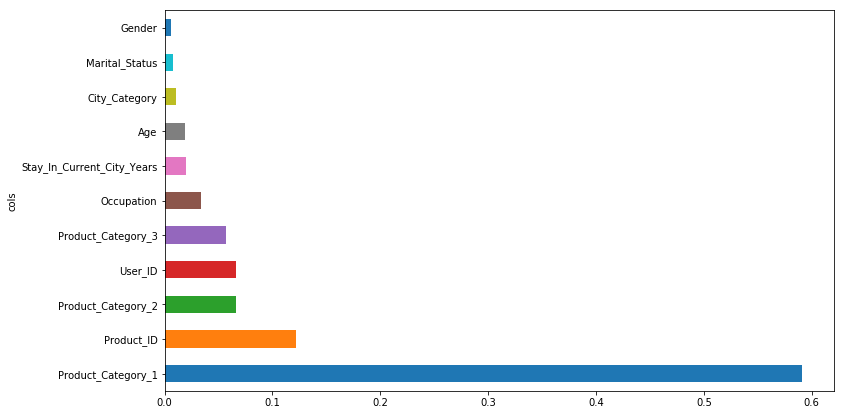

In [16]:
plot_fi(feat_imp_df[:40]);

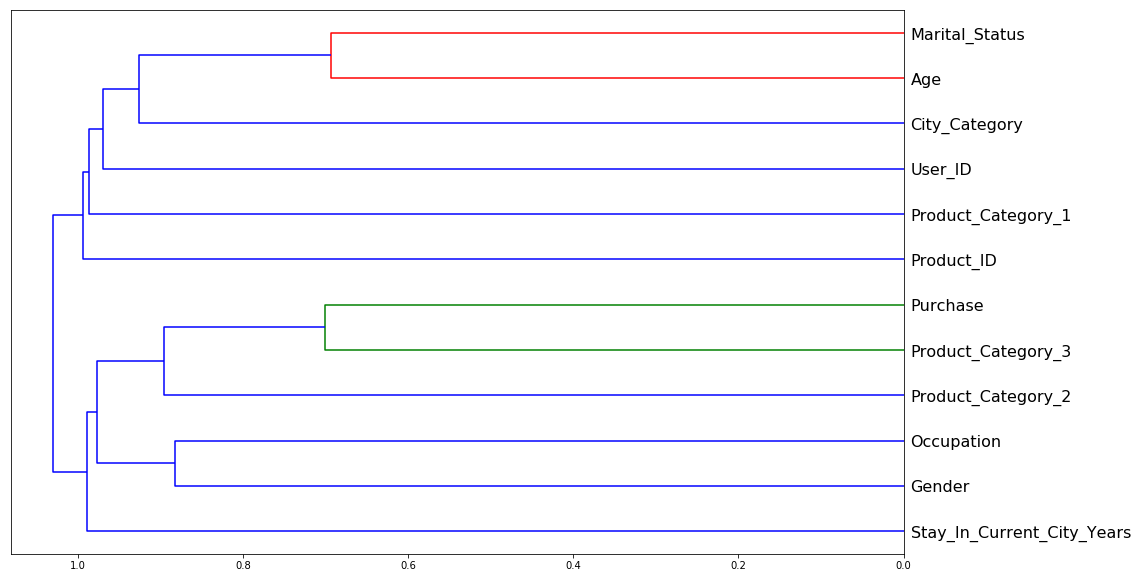

In [17]:
corr = np.round(scipy.stats.spearmanr(filled_df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=filled_df.columns, orientation='left', leaf_font_size=16)
plt.show()

In [29]:
df[df['Product_Category_1']  == 6]

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
25,1000009,P00135742,M,26-35,17,C,0,0,6,8.0,NaN,16662
44,1000010,P00148642,F,36-45,1,B,4+,1,6,10.0,13.0,12642
113,1000023,P00004742,M,36-45,0,B,3,1,6,16.0,NaN,8481
140,1000026,P00101342,M,26-35,7,B,2,1,6,8.0,NaN,16093
317,1000053,P00129842,M,26-35,0,B,1,0,6,8.0,15.0,16306
324,1000053,P00109242,M,26-35,0,B,1,0,6,8.0,10.0,20529
330,1000053,P00145942,M,26-35,0,B,1,0,6,8.0,13.0,20474
332,1000053,P00148842,M,26-35,0,B,1,0,6,8.0,16.0,16477
340,1000057,P00135742,M,18-25,19,C,2,0,6,8.0,NaN,12131
346,1000058,P00280742,M,26-35,2,B,3,0,6,8.0,NaN,16420


In [20]:
eli5.show_prediction(m, X.iloc[106], 
                     feature_names=list(X.columns),
                     show_feature_values=True)

In [22]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, X, X.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff55d3e6f98>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff55b489048>})

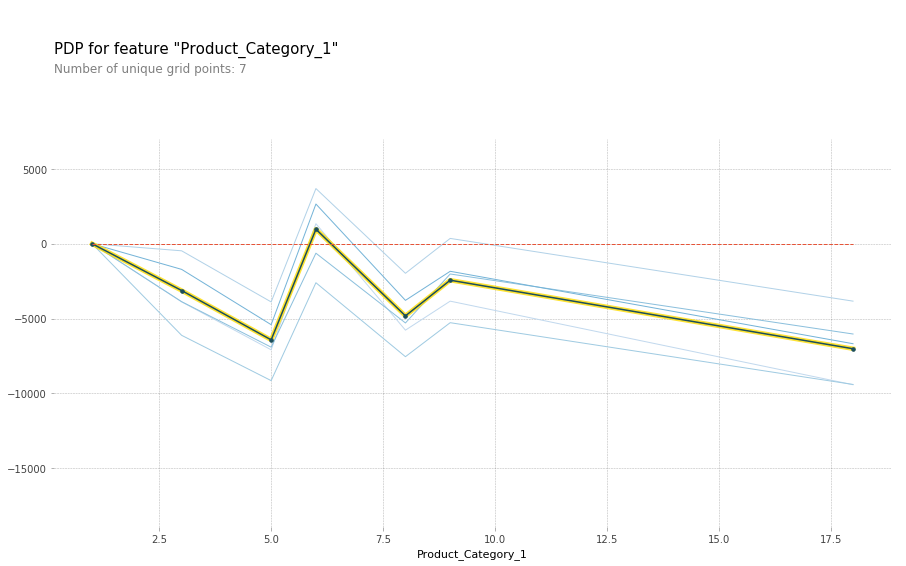

In [25]:
plot_pdp('Product_Category_1', clusters=5)

In [78]:
def feature_means(df,feature,label):
    means = {}
    vals = np.sort(df[feature].unique())
    for val in vals:
        val_mean = df[df[feature] == val][label].mean()
        means[val]=val_mean
    
    fig = plt.figure()
    x = np.linspace(1,len(means),len(means))
    plt.bar(means.keys(),means.values())
    plt.xticks(x)
    plt.show()

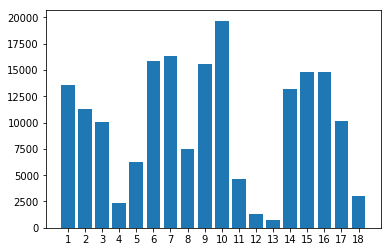

In [79]:
feature_means(df,'Product_Category_1','Purchase')

In [37]:
df[df['Product_Category_1'] == 6]['Purchase'].mean()

15837.893572703828

In [ ]:
def dummify(dataframe,threshold):
    dummy_vars = df.loc[:, df.apply(lambda x: x.nunique()) <= threshold]
    cat_vars = dataframe.drop(columns=dummy_vars.columns)
    dummies = pd.get_dummies(dummy_vars, dummy_na=True,columns=dummy_vars.columns)
    output = pd.concat([cat_vars,dummies],axis=1)
    return output

In [ ]:
dummy_df = dummify(X,7)
X_train, X_test, y_train, y_test = train_test_split(dummy_df, y, test_size=0.3, random_state=42)

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

In [ ]:
feat_imp_df = rf_feat_importance(m,X_train)
feat_imp_df[:10]

In [ ]:
plot_fi(feat_imp_df[:40]);